# Covid-19 en La Paz

> La mortalidad se ha reducido entre todos los grupos de edad. Cuando varias personas enferman en una vivienda suelen contagiarse primero los más jóvenes. Cada ola de contagios tiene un efecto diferente y progresivamente menor sobre la actividad comercial.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, dates, cm, colors
import locale
import geopandas as gpd
import datetime as dt
from IPython.display import display, Markdown
import json
locale.setlocale(locale.LC_TIME, "es_US.UTF8");
plt.style.use('publish/estilo.mplstyle')

/home/m/.virtualenvs/d/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Mortalidad por edad

La mortalidad por covid-19 es mayor en la población mayor a 60 años, y ha estado reduciéndose consistentemente a través de todos los grupos de edad.

In [5]:
def get_mortalidad(rango_size, freq):
    df = pd.read_csv('data/covid_lapaz/2022-02-07.csv', parse_dates=['registro', 'reporte'])
    df = df[(df.edad.notna()) & (df.registro.notna())]
    df['rango_edad'] = pd.cut(df.edad, bins=list(range(0,120, rango_size))).apply(lambda x: x.left)
    df = df[df.registro > '2020-03-01'].groupby([pd.Grouper(key='registro', freq=freq, label='right'), 'rango_edad']).caso.value_counts().reset_index(name='count').pivot_table(index=['registro', 'rango_edad'], columns='caso', values='count').reset_index().fillna(0)
    df['mortalidad'] = (df.fallecido / (df.fallecido + df.positivo + df.recuperado))
    df['registro'] = df.registro.apply(lambda x: x.replace(day=1))
    return df.pivot_table(index='registro', columns='rango_edad', values='mortalidad')

mortalidad = get_mortalidad(5, 'M')

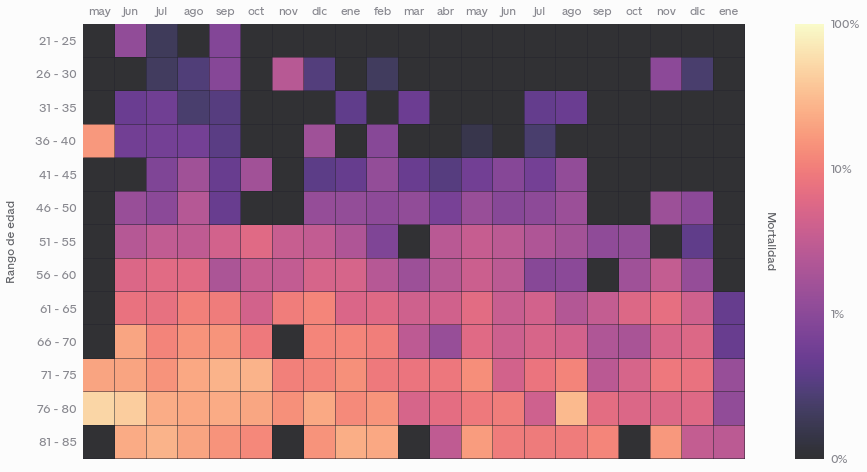

In [9]:
def plot_matrix(mortalidad, edad_min, edad_max, desde, hasta, rango_size):
    
    lincolor = '#88888f'
    titlecolor = '#1d1f26'
    background = '#fcfcfc'
    dfi = mortalidad.loc[desde:hasta, edad_min:edad_max].replace(0,.001)
    
    f, ax = plt.subplots(1,1,figsize=(15,8))
    f.set_facecolor(background)
    im = ax.imshow(dfi.T, cmap='magma', aspect='auto', norm=colors.LogNorm(vmin=.001, vmax=1.), alpha=.8, zorder=1)
    ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.columns)))))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(['{} - {}'.format(i + 1, i + rango_size) for i in dfi.columns]))
    ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.index)))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([i.strftime('%b') for i in dfi.index]))
    for axis, ticks in zip([ax.yaxis, ax.xaxis], [dfi.columns, dfi.index]):
        axis.set_minor_locator(ticker.FixedLocator([i + .485 for i in list(range(len(ticks)))]))
    ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)
    ax.tick_params(which='major', axis='x')
    ax.grid(which='minor', color='#24242e', linestyle='-', linewidth=.5, alpha=1, zorder=2)
    ax.annotate('Rango de edad', xy=(-.1, .5), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=titlecolor, rotation=90, alpha=.7)
    ax.annotate('Mortalidad', xy=(1.045, .5), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=titlecolor, rotation=270, alpha=.7)
    
    cbar = f.colorbar(im, shrink=1., pad=.06, aspect=15)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0)
    labels = cbar.ax.get_yticks()
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator(labels))
    cbar.ax.set_yticklabels(['{:.0%}'.format(i) for i in labels])
    cbar.ax.tick_params(labelcolor=lincolor)
    f.savefig('plots/mortalidad_edades_lp.png', bbox_inches='tight', pad_inches=.4)

plot_matrix(mortalidad, 20, 80, '2020-05-01', '2022-01-31', 5)

Esta reducción fue mayor en poblaciones más vulnerables:

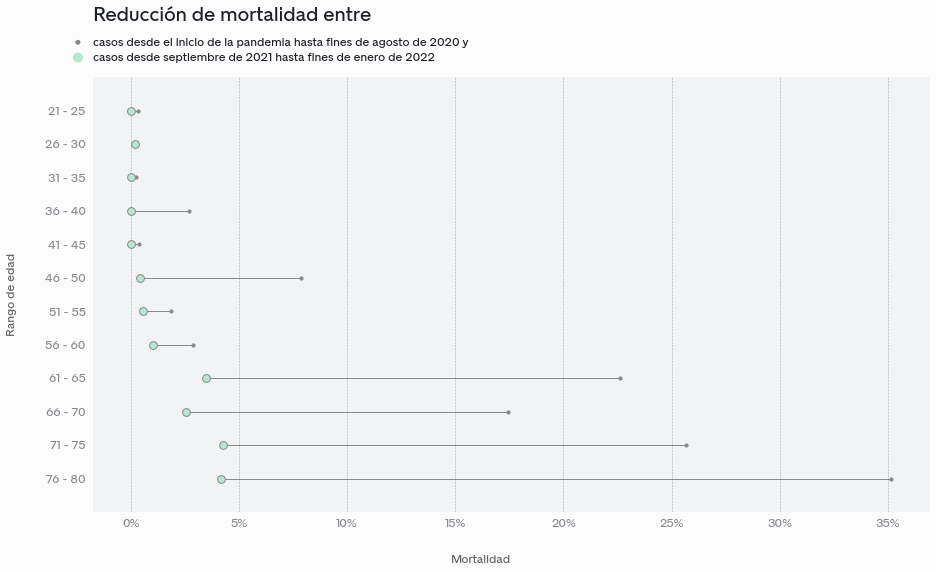

In [7]:
def plot_reduccion_mortalidad(periodo_1,periodo_2, edad_min, edad_max, etiquetas):
    dfi = pd.concat([periodo_1.mean(axis=0), periodo_2.mean(axis=0)], axis=1)
    dfi['delta'] = dfi[0] - dfi[1]
    dfi = dfi.loc[range(edad_min,edad_max,5)].sort_index()

    linecolor = '#88888f'
    background = '#fcfcfc'
    titlecolor = '#1d1f26'
    activecolor = '#b7e8cf'
    f, ax = plt.subplots(1,1,figsize=(15,8))
    f.set_facecolor(background)
    ax.scatter(dfi[0], dfi.index, s=10, color=linecolor, linewidth=1, edgecolor=linecolor, zorder=2)
    ax.scatter(dfi[1], dfi.index, s=60, color=activecolor, linewidth=1, edgecolor=linecolor, zorder=2)
    for i, row in dfi.iterrows():
        ax.plot([row[0], row[1]], [i, i], linewidth=1, color=linecolor, zorder=1)
    ax.grid(axis='x', linestyle='--', linewidth=.6)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    ax.yaxis.set_major_locator(ticker.FixedLocator(dfi.index))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(['{} - {}'.format(i+1, i+5) for i in dfi.index]))
    ax.tick_params(labelcolor=linecolor)
    ax.annotate('Reducción de mortalidad entre', xy=(0, 1.12), xycoords='axes fraction', fontsize=20, color=titlecolor, ha='left', va='bottom',)
    ax.annotate(etiquetas[0], xy=(0, 1.068), xycoords='axes fraction', fontsize=12, color=titlecolor, ha='left', va='bottom')
    ax.annotate('', xy=(-0.015, 1.08), xycoords='axes fraction', ha='right', va='center', fontsize=15, color=linecolor, xytext=(-.02, 1.08), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=5, linestyle='-', alpha=1))
    ax.annotate(etiquetas[1], xy=(0, 1.055), xycoords='axes fraction', fontsize=12, color=titlecolor, ha='left', va='top')
    ax.annotate('', xy=(-0.015, 1.045), xycoords='axes fraction', ha='right', va='center', fontsize=15, color=activecolor, xytext=(-.02, 1.045), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color='#b7e8cf', linewidth=10, linestyle='-', alpha=1))
    ax.annotate('Rango de edad', xy=(-.09, .5), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=titlecolor, rotation=90, alpha=.7)
    ax.annotate('Mortalidad', xy=(.5, -.11), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=titlecolor, alpha=.7)
    ax.set_ylim(dfi.index.max() + 5, dfi.index.min() - 5)
    f.savefig('plots/mortalidad_edades_cambio_lp.png', bbox_inches='tight', pad_inches=.4)
    
plot_reduccion_mortalidad(
    mortalidad.loc[:'2020-09-01'], 
    mortalidad.loc['2021-09-01':'2022-02-01'], 
    20, 
    80, 
    ['casos desde el inicio de la pandemia hasta fines de agosto de 2020 y', 
     'casos desde septiembre de 2021 hasta fines de enero de 2022']
)

## Dinámicas de contagio

Si la gente jóven tiende a ser más social y experimentar la enfermedad más lévemente, tiene menos incentivos para evitar situaciones de contagio. Estos contagios elevan el riesgo que otras poblaciones más vulnerables contraigan la enfermedad. Analizo si esta teoría se refleja en los datos de casos de covid-19 en La Paz. 

Primero observo el crecimiento semanal de casos por rango de edad para cada ola de contagios. Si la teoría es verdadera, debería ser posible distinguir un patrón donde el crecimiento de contagios entre gente mayor muestra un retraso respecto a jóvenes.

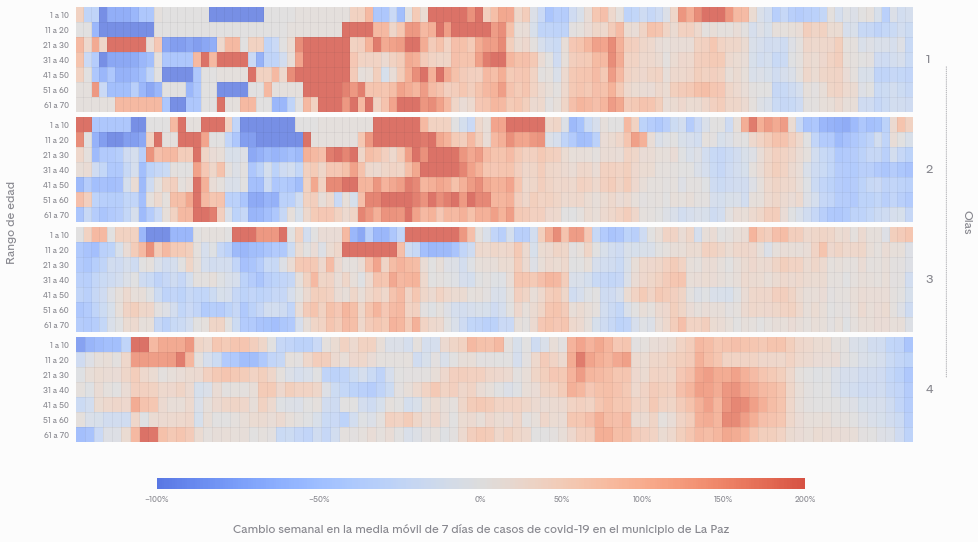

In [4]:
def get_casos():
    casos = pd.read_csv('data/covid_lapaz/2022-02-07.csv', parse_dates=['registro', 'reporte'])
    casos = casos[(casos.registro.notna()) & (casos.distrito.notna())]
    casos['distrito'] = casos['distrito'].astype(int)
    casos =  casos[['id', 'caso', 'sexo', 'edad', 'registro', 'distrito']]

    casos['rango_edad'] = pd.cut(casos.edad, bins=list(range(0,120, 10))).apply(lambda x: x.left)
    casos = casos[(casos.registro > '2020-01-01') & (casos.rango_edad >= 0) & (casos.rango_edad <= 80)]
    casos = casos.groupby([pd.Grouper(key='registro', freq='D'), 'rango_edad']).size().reset_index(name='casos').pivot_table(index='registro', columns='rango_edad', values='casos')
    casos = casos.rolling(7, center=True).mean().dropna()[range(0,70,10)]

    casos = casos.pct_change(periods=7)
    casos.replace([np.inf, -np.inf], .1, inplace=True)
    casos = casos.fillna(0)
    
    return casos

def plot_change(ax, casos, since, until):
        
    linecolor = '#88888f'
    background = '#fcfcfc'
    c = casos.copy()
    c = c.loc[since:until]
    linecolor = '#88888f'
    colormap = colors.ListedColormap(cm.get_cmap('coolwarm')(np.linspace(.1,.9, 255)))
    divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=2)
    ax.imshow(c.T, cmap=colormap, origin='lower', norm=divnorm, alpha=.8, aspect='auto')
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(c.columns))))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(['{} a {}'.format(i+1, i + 10) for i in c.columns]))
    ax.set_xticklabels([])
    ax.set_ylim(len(c.columns) - .5, -.5)
    for axis, ticks in zip([ax.yaxis, ax.xaxis], [c.columns, c.index]):
        axis.set_minor_locator(ticker.FixedLocator([i + .485 for i in list(range(len(ticks)))]))
    ax.tick_params(labelcolor=linecolor, labeltop=False, labelbottom=False, labelsize=8)
    ax.grid(which='minor', color='#24242e', linestyle='-', linewidth=.5, alpha=.1, zorder=2)

def plot_wavechange(casos):
    
    linecolor = '#88888f'
    background = '#fcfcfc'
    
    waves = [
        {'start': '2020-05-01', 'end': '2020-08-15'},
        {'start': '2020-11-01', 'end': '2021-02-15'},
        {'start': '2021-03-01', 'end': '2021-06-15'},
        {'start': '2021-11-01', 'end': '2022-02-07'}
    ]
    
    f, axs = plt.subplots(4,1,figsize=(15,8))
    f.set_facecolor(background)
    plt.subplots_adjust(hspace=.05)
    
    for i in range(0,4):
        plot_change(axs[i], casos, waves[i]['start'], waves[i]['end'])
             
    colormap = colors.ListedColormap(cm.get_cmap('coolwarm')(np.linspace(.1,.9, 255)))
    divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=2)
    
    cax = f.add_axes([0.2, 0.04, 0.60, 0.15])
    cax.set_axis_off()
    colorbar = plt.cm.ScalarMappable(norm=divnorm, cmap=colormap)
    cbar = f.colorbar(colorbar, ax=cax, orientation="horizontal", pad=.1, aspect=60)
    cbar.set_label(label="Cambio semanal en la media móvil de 7 días de casos de covid-19 en el municipio de La Paz",fontsize=12, color=linecolor,labelpad=20,)
    cbar.ax.tick_params(labelsize=8, labelcolor=linecolor)
    cbar.ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    cbar.outline.set_linewidth(0)
    
    axs[1].annotate('Rango de edad', xy=(-.07, 0), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=linecolor, rotation=90)
    
    for i in range(1,5):
        axs[i-1].annotate(i, xy=(1.015, .5), xycoords='axes fraction', ha='left', va='center', fontsize=12, color=linecolor, rotation=0)
        
    axs[1].annotate('Olas', xy=(1.07, 0), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=linecolor, rotation=270)
    axs[1].annotate('', xy=(1.04, 1.5), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=linecolor, xytext=(1.04, -1.5), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))

casos = get_casos()
plot_wavechange(casos)

In [2]:
def get_manzanos():
    manzanos = gpd.read_file('data/poblacion_2020.json')
    manzanos = manzanos[manzanos._municipio == 'La Paz'][['id', 'geometry']]
    return manzanos

def get_casos():
    casos = pd.read_csv('data/covid_lapaz/2022-02-07.csv', parse_dates=['registro', 'reporte'])
    casos = casos[(casos.edad.notna()) & (casos.registro.notna()) & (casos.lon.notna()) & (casos.lat.notna())]
    casos = gpd.GeoDataFrame(casos, geometry=gpd.points_from_xy(casos.lon, casos.lat), crs=manzanos.crs)
    return casos[['id', 'caso', 'sexo', 'edad', 'registro', 'geometry']]

def casos_en_manzanos():
    casos_manzanos = gpd.sjoin(manzanos, casos, op='contains')
    casos_manzanos.columns = ['manzano', 'geometry', 'i2', 'caso', 'resultado', 'sexo', 'edad', 'registro']
    casos_manzanos = casos_manzanos[['caso', 'manzano', 'registro', 'resultado', 'sexo', 'edad', 'geometry']]
    casos_manzanos = casos_manzanos.reset_index(drop=True)
    return casos_manzanos

def find_eventos(casos_manzanos, manzano):

    dfi = casos_manzanos[casos_manzanos.manzano == manzano].sort_values('registro')
    dfi = dfi[['manzano', 'caso', 'registro', 'resultado', 'sexo', 'edad']]
    dfi['timespan'] = dfi.registro - dfi.registro.shift(1)
    dfi.loc[dfi.timespan.isna(), 'timespan'] = dt.timedelta(days=0)

    unique_events = [0]
    eventlist = []
    event = 0
    for i, row in dfi.timespan.iteritems():
        if row > dt.timedelta(days=30):
            event += 1
            unique_events.append(event)
        eventlist.append(event)

    dfi['event'] = eventlist
    dfi = dfi[dfi.event.isin(pd.Series(unique_events)[dfi.groupby('event').size() >= 2].tolist())]
    
    events_df = []
    
    for i, event_df in dfi.groupby('event'):
        event_df['timespan'] = event_df.registro - event_df.registro.shift(1)
        event_df.loc[event_df.timespan.isna(), 'timespan'] = dt.timedelta(days=0)
        event_df['edad_relative'] = event_df.edad - event_df.edad.head(1).iloc[0]
        event_df['event'] = event_df[['manzano', 'event']].apply(lambda x: '{}_{}'.format(x[0], x[1]), axis=1)
        event_df['order'] = range(len(event_df))
        events_df.append(event_df)

    if len(events_df) > 0:
    
        events_df = pd.concat(events_df)
        events_df = events_df[['event', 'order', 'registro', 'timespan', 'caso', 'edad', 'edad_relative', 'sexo', 'resultado']]
        return events_df

manzanos = get_manzanos()
casos = get_casos()
casos_manzanos = casos_en_manzanos()

events = pd.concat([find_eventos(casos_manzanos, manzano) for manzano in casos_manzanos.manzano.unique()])
event_size = events.groupby('event').size()

/home/m/.virtualenvs/d/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
display(Markdown('\n\n'.join([
    'Como muestra el gráfico, este patrón parece reflejarse en todas las olas, excepto la tercera, entorno al pico de contagios. Periodos más distantes de este pico tienen un comportamiento más errático.',
    'Un mecanismo más específico que explicaría este fenómeno es que personas más jóvenes contraen la enfermedad en espacios de trabajo, reuniones sociales y transporte, y luego contagian a personas mayores en sus propias viviendas. Para investigar este mecanismo busco eventos donde al menos 2 personas contraen la enfermedad en un mismo manzano en menos de 30 días. Identifico {} eventos que cumplen estas condiciones entre el inicio de la pandemia y enero de 2022.'.format(len(events.event.unique())),
    'Encuentro que, entre eventos con al menos 5 personas, la edad promedio sube en cada nuevo contagio. La siguiente gráfica muestra la edad promedio (punto) y desviación estándar (línea) de los primeros 5 contagios para eventos que comienzan en cada ola. Puntos rojos indican que la edad promedio es mayor a la edad del primer caso. Este resultado sólo se mantiene para las 2 primeras olas de contagio, coherente con el anterior resultado. El patrón no cambia para eventos con otros números de contagios. Sin embargo, eventos con más contagios son más escasos y podrían ser sólo representativos de casos como contagios dentro de cárceles o grandes edificios. '
])))

Como muestra el gráfico, este patrón parece reflejarse en todas las olas, excepto la tercera, entorno al pico de contagios. Periodos más distantes de este pico tienen un comportamiento más errático.

Un mecanismo más específico que explicaría este fenómeno es que personas más jóvenes contraen la enfermedad en espacios de trabajo, reuniones sociales y transporte, y luego contagian a personas mayores en sus propias viviendas. Para investigar este mecanismo busco eventos donde al menos 2 personas contraen la enfermedad en un mismo manzano en menos de 30 días. Identifico 6701 eventos que cumplen estas condiciones entre el inicio de la pandemia y enero de 2022.

Encuentro que, entre eventos con al menos 5 personas, la edad promedio sube en cada nuevo contagio. La siguiente gráfica muestra la edad promedio (punto) y desviación estándar (línea) de los primeros 5 contagios para eventos que comienzan en cada ola. Puntos rojos indican que la edad promedio es mayor a la edad del primer caso. Este resultado sólo se mantiene para las 2 primeras olas de contagio, coherente con el anterior resultado. El patrón no cambia para eventos con otros números de contagios. Sin embargo, eventos con más contagios son más escasos y podrían ser sólo representativos de casos como contagios dentro de cárceles o grandes edificios. 

In [29]:
def wave_stats(events, column, size):

    event_matrix = events.pivot_table(index='event', columns='order', values=column).loc[events.groupby('event').registro.first().sort_values().index]

    waves = [
            {'start': '2020-05-01', 'end': '2020-08-15'},
            {'start': '2020-11-01', 'end': '2021-02-15'},
            {'start': '2021-03-01', 'end': '2021-06-15'},
            {'start': '2021-11-01', 'end': '2022-02-07'}
        ]

    wave_results = {}
    for i in range(4):
        dfi = event_matrix.loc[events[(events.order == 0) & (events.registro >= waves[i]['start']) & (events.registro <= waves[i]['end']) & (events.event.isin(event_size[event_size >= size].index))].event][range(size)]
        wave_results[i] = pd.concat([dfi.mean(), dfi.std()], axis=1)
        wave_results[i].columns = ['media', 'desviacion']
        
    return wave_results

def plot_wavestats(events, column, size, ylabel):

    linecolor = '#88888f'
    background = '#fcfcfc'

    f, axs = plt.subplots(4,1,figsize=(12,12), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=.05)
    f.set_facecolor(background)

    results = wave_stats(events, column, size)

    for i in range(4):
        ax = axs[i]
        result = results[i]
        base = result.loc[0, 'media']

        ax.scatter(result.index, result.media, color=['#ff9c9c' if m > base else '#e0e0e0' for m in result.media.tolist()], zorder=2, linewidth=1, s=50, edgecolor=linecolor)
        for i, row in result.iterrows():
            ax.plot([i] * 2, [row.media - row.desviacion, row.media + row.desviacion], color='#adaaaa', linewidth=.9, zorder=1)
        ax.grid(axis='y')
        ax.xaxis.set_major_locator(ticker.IndexLocator(1,0))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3, prune='both'))
        ax.tick_params(labelcolor=linecolor, labelsize=9)
        ax.axhline(base, color=linecolor,linestyle='--', linewidth=.8, zorder=1)
    
    axs[2].annotate(ylabel, xy=(-.05, 1.), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=linecolor, rotation=90)
    axs[-1].annotate('Orden de casos por evento de contagio', xy=(.5, -0.25), xycoords='axes fraction', ha='center', va='top', fontsize=12, color=linecolor)
    
    for i in range(1,5):
        axs[i-1].annotate(i, xy=(1.015, .5), xycoords='axes fraction', ha='left', va='center', fontsize=12, color=linecolor, rotation=0)
        
    axs[2].annotate('Olas', xy=(1.08, 1.), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=linecolor, rotation=270)
    axs[2].annotate('', xy=(1.05, -.5), xycoords='axes fraction', ha='right', va='center', fontsize=12, color=linecolor, xytext=(1.05, 2.5), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))

**Eventos con al menos 5 contagios**

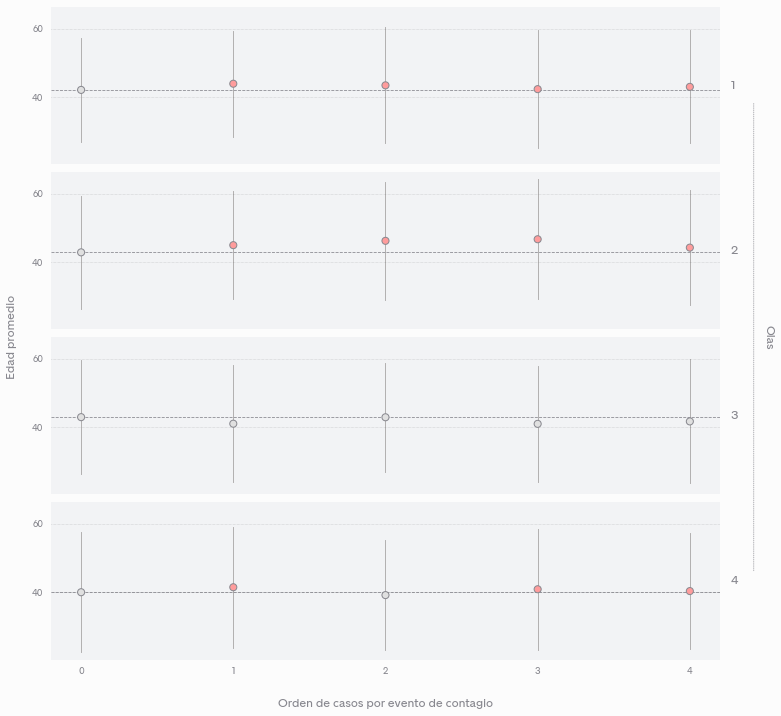

In [30]:
display(Markdown('**Eventos con al menos 5 contagios**'))
plot_wavestats(events, 'edad', 5, 'Edad promedio')

**Eventos con al menos 3 contagios**

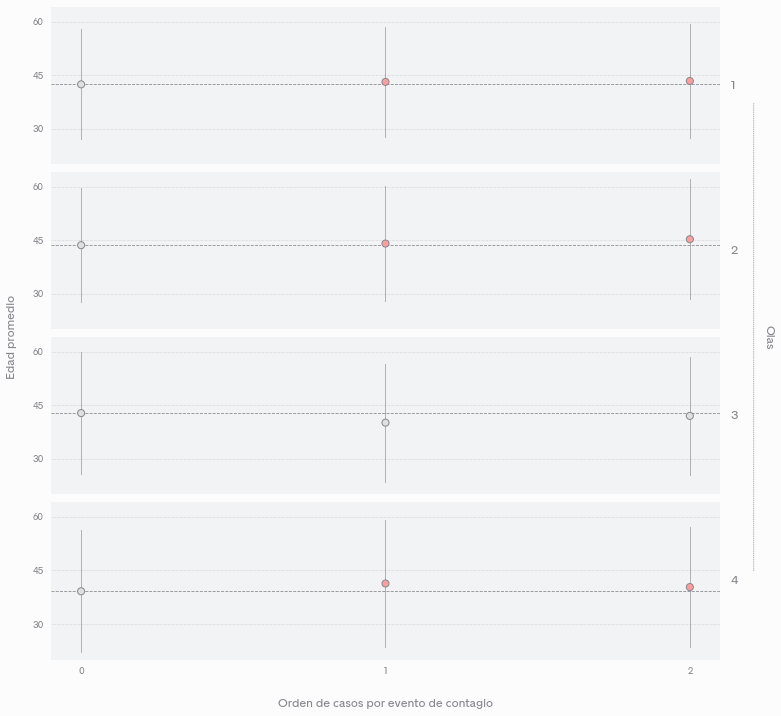

In [31]:
display(Markdown('**Eventos con al menos 3 contagios**'))
plot_wavestats(events, 'edad', 3, 'Edad promedio')

**Eventos con al menos 10 contagios**

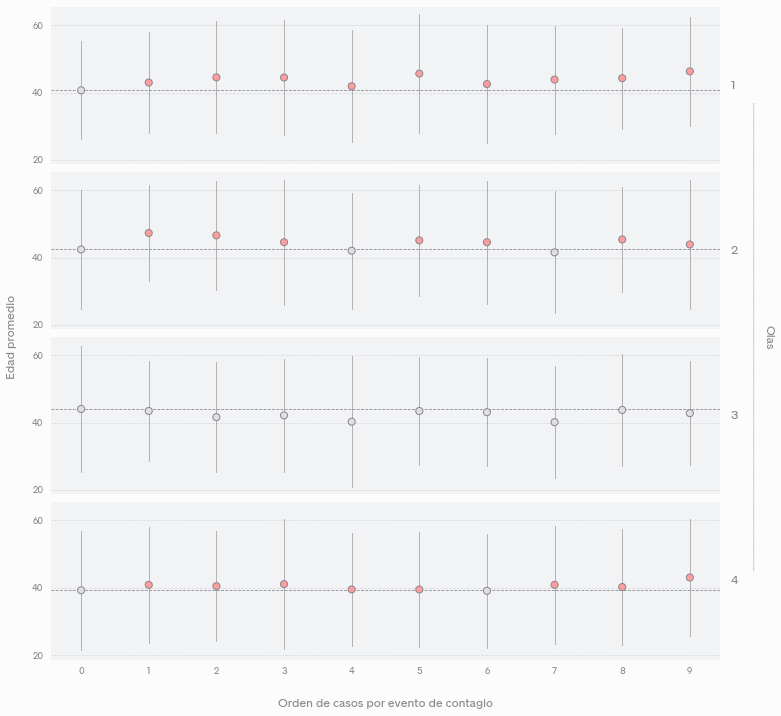

In [32]:
display(Markdown('**Eventos con al menos 10 contagios**'))
plot_wavestats(events, 'edad', 10, 'Edad promedio')

## Efecto sobre la actividad económica

El crecimiento de contagios motiva a que personas se distancien, crea incertidumbre y fricciones para la toma de decisiones y en algunos casos, por ejemplo cuando se norman medidas de emergencia como cuarentenas, puede congelar actividades económicas completamente. Para comprender el efecto del crecimiento de contagios sobre el dinamismo económico en la ciudad de La Paz, observo el número de registros de inmuebles para actividades comerciales por distrito. Este registro es un requerimiento para que una empresa o persona abra un establecimiento destinado al comercio o servicios, y su crecimiento debería ser un reflejo de la actividad en el sector comercial, de servicios, bienes raíces y la administración pública. Observo cómo vaŕia el número de registros por distrito entre 6 semanas antes y dos semanas después del pico de cada ola de contagios. Cada ola parece frenar la actividad económica de forma diferente. La primera ola detiene el crecimiento que genera el levantamiento de la cuarentena estricta. La segunda ola coincide con fin de año y retrasa la normalización posterior de actividades. Y la tercera ola es más leve y su efecto es más heterogeneo. Cada cuadro en el siguente gráfico representa la media (punto) y desviación estándar (línea) del número de registros de inmuebles por distrito y semana, para cada ola de contagios.

In [51]:
def get_casos():
    casos = pd.read_csv('data/covid_lapaz/2022-02-07.csv', parse_dates=['registro', 'reporte'])
    casos = casos[(casos.registro.notna()) & (casos.distrito.notna())]
    casos['distrito'] = casos['distrito'].astype(int)
    return casos[['id', 'caso', 'sexo', 'edad', 'registro', 'distrito']]

def get_inmuebles():
    inmuebles = gpd.read_file('data/inmueble_actividad_economica.geojson', parse_dates=['fecha_registro', 'fecha_modificacion'])[['id', 'tipo_objeto_tributario', 'fecha_registro', 'distrito']]
    inmuebles = inmuebles[(inmuebles.distrito.notna()) & (inmuebles.fecha_registro.notna())]
    inmuebles['registro'] = pd.to_datetime(pd.to_datetime(inmuebles.fecha_registro).dt.date)
    inmuebles = inmuebles[inmuebles.distrito.isin([str(i) for i in range(0,30)])]
    inmuebles.distrito = inmuebles.distrito.astype(int)
    return inmuebles

def make_inmuebles_casos(freq):
    casos = get_casos()
    inmuebles = get_inmuebles()
    inmuebles_casos = pd.concat([inmuebles.groupby([pd.Grouper(key='registro', freq=freq), 'distrito']).size(), casos[casos.registro > '2020-03-01'].groupby([pd.Grouper(key='registro', freq=freq), 'distrito']).size()], axis=1)
    inmuebles_casos.columns = ['inmuebles', 'casos']
    inmuebles_casos = inmuebles_casos.reset_index().fillna(0)
#     inmuebles_casos = inmuebles_casos[inmuebles_casos.registro >= '2020-03-01']
    return [inmuebles_casos.pivot_table(index='registro', columns='distrito', values=col).fillna(0) for col in ['inmuebles', 'casos']]

def get_wavestats(wave, compare_base=False, years_compare=1):
    
    waves = {
        1: {'start': '2020-05-01', 'end': '2020-08-15'},
        2: {'start': '2020-11-01', 'end': '2021-02-15'},
        3: {'start': '2021-03-01', 'end': '2021-06-15'},
        4: {'start': '2021-11-01', 'end': '2022-02-07'}
    }
    
    wave_start = waves[wave]['start']
    wave_end = waves[wave]['end']

    registros = []
    base = []
    
    for distrito in range(1,23):
        pico = casos.loc[wave_start:wave_end, distrito].sort_values().tail(1).index
        start = casos.index[list(casos.index).index(pico) - 6]
        end = casos.index[list(casos.index).index(pico) + 2]
        registros.append(inmuebles.loc[start:end, distrito].reset_index(drop=True))
        if compare_base:
            base.append(inmuebles.loc[start - dt.timedelta(days=370 * years_compare) : end - dt.timedelta(days=360 * years_compare), distrito].reset_index(drop=True))
    
    
    registros = pd.concat(registros, axis=1)
    registros = pd.concat([registros.mean(axis=1), registros.std(axis=1)], axis=1)
    registros.columns = ['media', 'desviacion']
    
    if compare_base:
        base = pd.concat(base, axis=1)
        base = pd.concat([base.mean(axis=1), base.std(axis=1)], axis=1)
        base.columns = ['media', 'desviacion']
        return registros, base
    else:
        return registros        

def plot_wave(ax, registros, color='#ff9c9c', alpha=1.):
    
    linecolor = '#88888f'

    for i, row in registros.iterrows():
        ax.plot([i] * 2, [row.media - row.desviacion, row.media + row.desviacion], color='#adaaaa', linewidth=.9, zorder=1, alpha=alpha)

    ax.scatter(registros.index, registros.media, color=color, s=50, zorder=2, linewidth=1, edgecolor=linecolor, alpha=alpha)

    ax.grid(axis='y')
    ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(10))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([-6 + i for i in range(10)]))
    ax.tick_params(labelcolor=linecolor, labelsize=9)

def plot_waves():
    
    linecolor = '#88888f'

    f, axs = plt.subplots(1,4,figsize=(15,10), sharey=True)
    plt.subplots_adjust(wspace=.05)

    for ax, wave in zip(axs, range(1,5)):
        registros = get_wavestats(wave)
        plot_wave(ax, registros)
        ax.annotate(wave, xy=(.5, 1.02), xycoords='axes fraction', color=linecolor, ha='center', va='bottom', fontsize=16)
        ax.axvline(6, color=linecolor, linestyle='--', linewidth=.8, alpha=.5)
        
    axs[0].annotate('Inmuebles comerciales registrados por semana', xy=(-.16, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=linecolor, rotation=90)
    axs[1].annotate('Semanas antes y después del pico de la ola', xy=(.5, -.08), xycoords='axes fraction', ha='center', va='top', fontsize=14, color=linecolor)
    
def compare_wave(wave, years_compare=1):
    
    linecolor = '#88888f'

    f, ax = plt.subplots(1,1,figsize=(10,10), sharey=True)
    plt.subplots_adjust(wspace=.05)
    
    registros, base = get_wavestats(wave, True, years_compare)
    base.index = [i-.05 for i in base.index]
    registros.index = [i+.05 for i in registros.index]
    plot_wave(ax, base, color='#e0e0e0', alpha=.5)
    plot_wave(ax, registros)
    ax.grid(axis='y')
    
    ax.annotate('Inmuebles comerciales registrados por semana', xy=(-.07, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=linecolor, rotation=90)
    ax.annotate('Semanas antes y después del pico de la ola y semana comparable un año antes', xy=(.5, -.07), xycoords='axes fraction', ha='center', va='top', fontsize=14, color=linecolor)
    
# inmuebles, casos = make_inmuebles_casos(freq='W')

**Comportamiento del registro de inmuebles para actividades comerciales entorno al pico de cada ola de contagios**

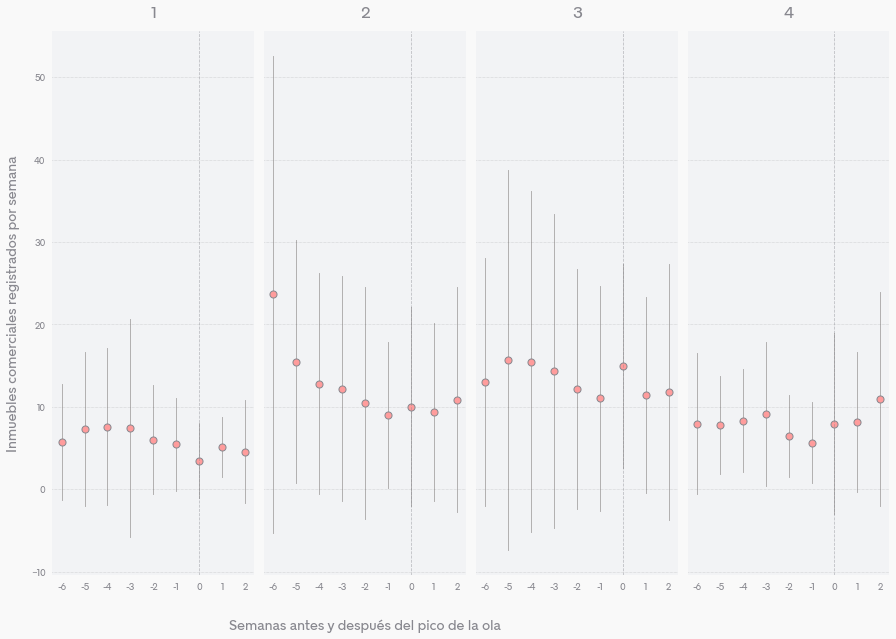

In [39]:
display(Markdown('**Comportamiento del registro de inmuebles para actividades comerciales entorno al pico de cada ola de contagios**'))
plot_waves()

Sin embargo, una estimación del efecto requiere al menos una línea base que capture la tendencia del número de registros en un año normal. Como sólo cuento con datos de registros desde septiembre de 2019, sólo podría comparar la tendencia durante la segunda ola con el comportamiento un año antes. En la siguiente gráfica muestro esta comparación, donde registros de un año antes se encuentran en gris. Queda claro que el crecimiento de contagios frena la normalización de actividades desde al menos 2 semanas antes del pico de la ola. 

**Comportamiento del registro de inmuebles durante la segunda ola y un año antes**

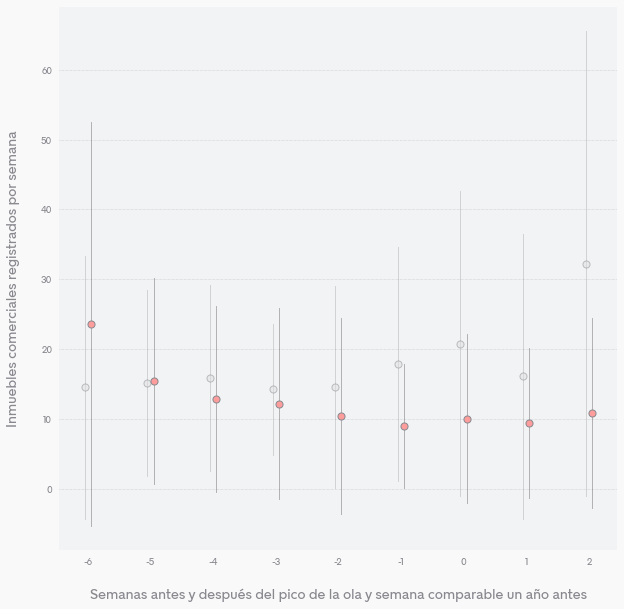

In [52]:
display(Markdown('**Comportamiento del registro de inmuebles durante la segunda ola y un año antes**'))
compare_wave(2)